# [Optional] Generate expert trajectories

**Note : This repository already includes expert dataset and you don't need to run this script.** (This script is for building dataset by yourself.)

Before running algorithms in imitaiton learning, we need expert's trajectories, which are used to learn behaviors or to recover rewards.<br>
In this example, we generate optimal policy by applying reinforcement learning method (here I use PPO algorithm), and generate expert's trajectories with this trained agent.

It's also worth noting that we use reward's function to get the optimal agent in this notebook, but reward's function cannot be used in all imitation learning exercises in this repository.<br>
That's why the methods in imitation learning matters.

See [here](https://github.com/tsmatz/reinforcement-learning-tutorials) for theoretical background behind reinforcement learning algorithms. (Explanation of RL is out of scope in this repository.)

*(back to [index](https://github.com/tsmatz/imitation-learning-tutorials/))*

Before we start, we need to install the required packages.

In [ ]:
!pip install torch numpy matplotlib

## 1. Define GridWorld environment

First we define GridWorld environment to be used in all exercises.

In [1]:
import numpy as np
import random
import torch
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GRID_SIZE = 50
MAX_TIMESTEP = 200
GOAL_REWARD = 10

class GridWorld:
    """
    This environment is motivated by the following paper.
    https://proceedings.mlr.press/v15/boularias11a/boularias11a.pdf

    - It has 50 x 50 grids (cells).
    - The agent has four actions for moving in one of the directions of the compass.
    - [Optional] If ```transition_prob``` = True, the actions succeed with probability 0.7,
      a failure results in a uniform random transition to one of the adjacent states.
    - A reward of 10 is given for reaching the goal state, located on the bottom-right corner.
    - For the remaining states,
      the reward function was randomly set to 0 with probability 2/3
      and to −1 with probability 1/3.
    - If the agent moves across the border, it's given the fail reward (i.e, reward=`-1`).
    - The initial state is sampled from a uniform distribution.
    """

    def __init__(self, seed=None, reward_map=None, valid_states=None, transition_prob=True):
        """
        Initialize class.

        Parameters
        ----------
        seed : int
            Seed value to generate new grid (maze).
            When seed is None, it copies ```reward_map``` and ```valid_states``` from arguments.
            When seed is not None, it creates a new grid with this seed.
            (The ```reward_map``` and ```valid_states``` are newly generated.)
        reward_map : int[GRID_SIZE * GRID_SIZE]
            Set this, when seed is None.
        valid_states : list(int[2])
            Set this, when seed is None.
        transition_prob : bool
            True if transition probability (above) is enabled.
            False when we generate an expert agent without noise.
        """
        self.transition_prob = transition_prob
        if seed is not None:
            ### Generate new GridWorld ###
            # generate grid
            reward_map = np.zeros(GRID_SIZE * GRID_SIZE, dtype=int)
            # bottom-right is goal state (reward=GOAL_REWARD)
            reward_map[GRID_SIZE * GRID_SIZE - 1] = GOAL_REWARD
            # set reward=−1 with probability 1/3
            sample_n = np.floor((GRID_SIZE * GRID_SIZE - 1) / 3).astype(int)
            rng = np.random.default_rng(seed)
            sample_loc = rng.choice(GRID_SIZE * GRID_SIZE - 1, size=sample_n, replace=False)
            for loc in sample_loc:
                reward_map[loc] = -1
            # generate state-reward map (GRID_SIZE*GRID_SIZE,)
            self.reward_map = torch.from_numpy(reward_map).to(device)
            # seek valid states
            self.valid_states = self._greedy_seek_valid_states((GRID_SIZE-1, GRID_SIZE-1), [])
            self.valid_states.remove((49, 49))
        else:
            ### Load from JSON ###
            self.reward_map = torch.tensor(reward_map).to(device)
            self.valid_states = [tuple(s) for s in valid_states]

    def _greedy_seek_valid_states(self, state, old_state_list):
        """
        This method recursively seeks valid state.
        e.g, if some state is surrounded by the states with reward=-1,
        this state is invalid, because it cannot reach to the goal state
        without losing rewards.

        Parameters
        ----------
        state : tuple(int, int)
            State to start seeking. It then seeks this state and all child's states.
            This state must be the tuple of (row, column).
        old_state_list : list(tuple(int, int)))
            List of states already checked.
            Each state must be the tuple of (row, column).
            These items are then skipped for seeking.

        Returns
        ----------
        valid_states : list(tuple(int, int))
            List of new valid states.
            Each state must be the tuple of (row, column).
        """
        # build new list
        new_state_list = []
        # if the state is already included in the list, do nothing
        if state in old_state_list:
            return new_state_list
        # if the state has reward=-1, do nothing
        if self.reward_map[state[0]*GRID_SIZE+state[1]] == -1:
            return new_state_list
        # else add the state into the list
        new_state_list.append(state)
        # move up
        if state[0] > 0:
            next_state = tuple(map(lambda i, j: i + j, state, (-1, 0)))
            new_state_list += self._greedy_seek_valid_states(
                next_state,
                old_state_list + new_state_list)
        # move down
        if state[0] < GRID_SIZE - 1:
            next_state = tuple(map(lambda i, j: i + j, state, (1, 0)))
            new_state_list += self._greedy_seek_valid_states(
                next_state,
                old_state_list + new_state_list)
        # move left
        if state[1] > 0:
            next_state = tuple(map(lambda i, j: i + j, state, (0, -1)))
            new_state_list += self._greedy_seek_valid_states(
                next_state,
                old_state_list + new_state_list)
        # move right
        if state[1] < GRID_SIZE - 1:
            next_state = tuple(map(lambda i, j: i + j, state, (0, 1)))
            new_state_list += self._greedy_seek_valid_states(
                next_state,
                old_state_list + new_state_list)
        # return result
        return new_state_list

    def reset(self, batch_size):
        """
        Randomly, get tensor of initial states (multiple) from valid states.
        This method performs as a batch.

        Parameters
        ----------
        batch_size : int
            The number of returned states.

        Returns
        ----------
        states : tensor of int[BATCH_SIZE, 2]
            The initialized states.
            Each single state must be tensor([row, column]). (The shape is torch.Size([2]).)
        """
        # initialize step count
        self.step_count = 0
        # pick up samples of valid states (batch_size, 2)
        states_2d = random.sample(self.valid_states, batch_size)
        return torch.from_numpy(np.array(states_2d)).to(device)

    def step(self, actions, states):
        """
        Take action, proceed step, and return the results as tensor.
        This method performs as a batch.

        Parameters
        ----------
        actions : tensor of int[BATCH_SIZE]
            Actions to take
            (0=UP 1=DOWN 2=LEFT 3=RIGHT)
        states : tensor of int[BATCH_SIZE, 2]
            Current states.
            Each single state must be tensor([row, column]). (The shape is torch.Size([2]).)

        Returns
        ----------
        new-states : tensor of int[BATCH_SIZE, 2]
            New states.
            Each single state must be tensor([row, column]). (The shape is torch.Size([2]).)
        rewards : tensor of int[BATCH_SIZE]
            The obtained rewards.
        done : tensor of bool[BATCH_SIZE]
            Flags to check whether it terminates.
        """
        # get batch size
        batch_size = actions.shape[0]
        # if transition prob is enabled, apply transition
        if self.transition_prob:
            # the action succeeds with probability 0.7
            prob = torch.ones(batch_size, 4).to(device)
            mask = F.one_hot(actions, num_classes=4).bool()
            prob = torch.where(mask, 7.0, prob)
            selected_actions = torch.multinomial(prob, 1, replacement=True)
            selected_actions = selected_actions.squeeze(dim=1)
        else:
            selected_actions = actions
        # move state
        # (0=UP 1=DOWN 2=LEFT 3=RIGHT)
        one_hot = F.one_hot(selected_actions, num_classes=4)
        up_and_down = one_hot[:,1] - one_hot[:,0]
        up_and_down = up_and_down.unsqueeze(dim=1)
        left_and_right = one_hot[:,3] - one_hot[:,2]
        left_and_right = left_and_right.unsqueeze(dim=1)
        move = torch.cat((up_and_down, left_and_right), dim=1)
        new_states = states + move
        # if location is out of border, set reward=-1
        rewards = torch.zeros(batch_size).to(device)
        rewards = torch.where(new_states[:,0] < 0, -1.0, rewards)
        rewards = torch.where(new_states[:,0] >= GRID_SIZE, -1.0, rewards)
        rewards = torch.where(new_states[:,1] < 0, -1.0, rewards)
        rewards = torch.where(new_states[:,1] >= GRID_SIZE, -1.0, rewards)
        # correct location
        new_states = torch.clip(new_states, min=0, max=GRID_SIZE-1)
        # if succeed, add reward of current state
        states_1d = new_states[:,0] * GRID_SIZE + new_states[:,1]
        rewards = torch.where(rewards>=0.0, rewards+self.reward_map[states_1d], rewards)
        # return results
        self.step_count += 1
        return new_states, rewards, torch.logical_or(rewards==GOAL_REWARD, torch.tensor(self.step_count==MAX_TIMESTEP))

Create environment with a fixed seed 1000.<br>
To speed up training, transition probability is disabled in this environment. (i.e, `transition_prob=False`)

In [2]:
env = GridWorld(1000, transition_prob=False)

Now I visualize our GridWorld environment.

The number indicates the reward score in this state.<br>
The goal state is in the right-bottom corner. The highlighted cells are valid state, in which the agent can reach to goal state without losing any rewards.

In [3]:
from IPython.display import HTML, display

# show grid
html_text = "<table>"
for row in range(GRID_SIZE):
    html_text += "<tr>"
    for col in range(GRID_SIZE):
        if ((row, col) in env.valid_states) or ((row, col) in [(49, 49)]):
            html_text += "<td bgcolor=\"gray\">"
        else:
            html_text += "<td>"
        html_text += str(env.reward_map[row*GRID_SIZE+col].tolist())
        html_text += "</td>"
    html_text += "</tr>"
html_text += "</table>"

display(HTML(html_text))

0,-1,0,0,0,-1,0,0,0,0,0,0,-1,0,-1,-1,-1,-1,0,-1,0,-1,0,0,0,-1,0,0,0,-1,-1,0,-1,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0
-1,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,-1,0,-1,0,-1,0,-1,0,-1,-1,0,0,0,-1,-1,0,0,-1,-1
0,0,-1,-1,0,-1,0,-1,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,-1,0,0,0
0,0,-1,0,-1,-1,0,0,-1,0,-1,0,0,0,0,-1,0,-1,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1
-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,0,0
0,-1,-1,0,0,-1,0,-1,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,-1,0,0,0,0,-1,-1,0,0,-1,0,-1,-1,-1,-1,0,0,-1,0,-1,0,0,0,0,0,-1
-1,-1,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,0,0,-1,-1,0,0,-1,-1,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,-1,-1,0,0,0,-1,0,-1,0,-1,-1
0,0,0,0,-1,0,0,0,-1,0,0,0,0,-1,0,0,-1,-1,0,0,-1,0,0,-1,0,0,-1,0,0,0,-1,-1,0,0,-1,0,-1,0,-1,0,0,-1,0,-1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,-1,0,0,-1,-1,0,0,0,0,0,0,-1,0,0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,0,-1,0,0,0,-1,0,0,0,0
0,0,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,-1,0,-1,-1,-1
0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,-1,-1,0,-1,-1,0,0,0,0,0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0


### Optional

Save (serialize) this environment as JSON in order to recover the same environment in the following examples.

**Note : This repository already has this JSON file (```gridworld.json```) and you don't need to run this cell.**

In [ ]:
import json

def serialize_gridworld(env):
    env_dict = env.__dict__
    reward_map_list = env_dict["reward_map"].tolist()
    return {
        "reward_map": reward_map_list,
        "valid_states": env_dict["valid_states"]
    }

with open("gridworld.json", "w") as f:
    json_str = json.dumps(env, default=serialize_gridworld)
    f.write(json_str)

When you create GridWorld environment using the existing JSON file (```gridworld.json```), please run this cell.

In [ ]:
import json

with open("gridworld.json", "r") as f:
    json_object = json.load(f)
    env = GridWorld(**json_object, transition_prob=False)

## 2. Define models

Now we define and instantiate the expert model (neural network) by using state-of-the-art reinforcement learning algorithm, PPO (Proximal Policy Optimization).<br>
Here I don't explain the algorithm about PPO, but please refer [reinforcement learning tutorial's repository](https://github.com/tsmatz/reinforcement-learning-tutorials) for details.<br>
In PPO, it uses 2 models - actor model and value model. Firstly, I then define these 2 models as follows. (Later these models will be trained.)

I note that GridWorld is a primitive environment and I assume that both the action (logits) and value is linear to the feature of state, i.e, $\verb|estimated value| = \mathbf{w}^T \cdot \phi(s) $, where $\phi(s)$ is the feature of state $s$.<br>
Thus, both networks have no hidden layers (see below) to speed up the training. (Depending on promblems, you should define more large models.)

In [4]:
import torch.nn as nn

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.output = nn.Linear(GRID_SIZE*GRID_SIZE, 4, bias=False)

    def forward(self, state, mask=None):
        """
        Set mask (size (TIMESTEP_SIZE, BATCH_SIZE)), when the number of timestep differs.
        """
        logits = self.output(state)
        if mask is not None:
            mask = mask.unsqueeze(dim=-1)
            mask = mask.expand(-1, -1, 4)
            logits = logits.masked_fill(mask, 0.0)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.output = nn.Linear(GRID_SIZE*GRID_SIZE, 1, bias=False)

    def forward(self, state, mask=None):
        """
        Set mask (size (TIMESTEP_SIZE, BATCH_SIZE)), when the number of timestep differs.
        """
        value = self.output(state)
        if mask is not None:
            mask = mask.unsqueeze(dim=-1)
            value = value.masked_fill(mask, 0.0)
        return value

#
# Generate model
#
actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

I also define the helper functions for these models as follows.

In [5]:
# Get feature vectors (which shape is (GRID_SIZE*GRID_SIZE,)) of state to feed models
def get_feature(states_2d):
    """
    Return one-hot feature array from 2d states (as a batch).
    e.g, [[0,3], [0,2]] -->
      [
        [0, 0, 0, 1, 0, ... ],
        [0, 0, 1, 0, 0, ... ]
      ]
    """
    # convert 2d index to 1d index --> size (batch_size, )
    states_1d = states_2d[:,0] * GRID_SIZE + states_2d[:,1]
    # get one-hot array --> size (batch_size, GRID_SIZE * GRID_SIZE)
    return F.one_hot(states_1d, num_classes=GRID_SIZE*GRID_SIZE)

# Pick stochastic samples with previous actor model
def pick_sample_and_logp(policy, s):
    """
    Stochastically pick up action and logits with policy model.

    Parameters
    ----------
    policy : torch.nn.Module
        Policy network to use
    s : tensor of int[GRID_SIZE*GRID_SIZE])
        The feature (one-hot) of state.

    Returns
    ----------
    action : tensor of int
        The picked-up actions.
    logits : tensor of int[4]
        Logits defining categorical distribution.
        This is needed to optimize model.
    """
    with torch.no_grad():
        # Get logits from state
        # --> size : (BATCH_SIZE, 4)
        logits = policy(s.float())
        # From logits to probabilities
        # --> size : (BATCH_SIZE, 4)
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        # --> size : (BATCH_SIZE, 1)
        a = torch.multinomial(probs, num_samples=1)
        # --> size : (BATCH_SIZE, )
        a = a.squeeze(dim=1)
        # Calculate log probability
        logprb = -F.cross_entropy(logits, a, reduction="none")

        # Return
        return a, logits, logprb

## 3. Train and generate expert model (Optional)

**Note : This repository already has trained models (```expert_actor.pt```, ```expert_value.pt```) and you don't need to run this cell.**

Now let's train above models with PPO algorithm.<br>

In this notebook, I have just used the source code in [reinforcement learning tutorial's repository](https://github.com/tsmatz/reinforcement-learning-tutorials) without any explanation, but please refer the original repository for theoretical background behind PPO.

In this training,

- To speed up training, it runs training as a batch.
- The environment doesn't have transition probability and the optimal total reward in a single episode becomes `10.0`.
- The goal for the agent is to reach the goal state without losing rewards. Thus, I have set no discount rate (```DISCOUNT = 1.0```).

> Here I set ```-100``` as unknown action, because PyTorch cross-entropy function (```torch.nn.functional.cross_entropy()```) has a property ```ignore_index``` which default value is ```-100```.

In [4]:
#
# Train model
# 
# copied and modified from :
# https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/04-ppo.ipynb
#

DISCOUNT = 1.0            # No Discount
LEARNING_RATE = 0.001
BATCH_SIZE = 128

# [TODO] change this value if transition_prob=TRUE
THRESHOLD = 9.0  # if transition_prob=FALSE
# THRESHOLD = -0.95  # if transition_prob=TRUE

# These coefficients are experimentally determined in practice.
kl_coeff = 100000.0  # weight coefficient for KL-divergence loss
vf_coeff = 100.00  # weight coefficient for value loss

reward_records = []
all_params = list(actor_func.parameters()) + list(value_func.parameters())
opt = torch.optim.AdamW(all_params, lr=LEARNING_RATE)
for i in range(999999):

    #
    # Run episode till done as a batch to generate tensors
    #
    done = torch.tensor([False]).to(device)
    # define working items
    # (tensor shape is (TIMESTEP_SIZE, BATCH_SIZE) or (TIMESTEP_SIZE, BATCH_SIZE, C) where C is the number of classes)
    states_work = torch.empty((0,BATCH_SIZE,GRID_SIZE*GRID_SIZE), dtype=torch.int).to(device)
    actions_work = torch.empty((0,BATCH_SIZE), dtype=torch.int).to(device)
    logits_work = torch.empty((0,BATCH_SIZE,4), dtype=torch.float).to(device)
    logprbs_work = torch.empty((0,BATCH_SIZE), dtype=torch.float).to(device)
    rewards_work = torch.empty((0,BATCH_SIZE), dtype=torch.float).to(device)
    # define done items
    states_done = []
    actions_done = []
    logits_done = []
    logprbs_done = []
    rewards_done = []
    # start
    s = env.reset(BATCH_SIZE)
    while not (torch.prod(done) == 1):
        s_onehot = get_feature(s)
        states_work = torch.cat((states_work, s_onehot.unsqueeze(dim=0)), dim=0)
        a, l, p = pick_sample_and_logp(actor_func, s_onehot)
        s, r, done = env.step(a, s)
        actions_work = torch.cat((actions_work, a.unsqueeze(dim=0)), dim=0)
        logits_work = torch.cat((logits_work, l.unsqueeze(dim=0)), dim=0)
        logprbs_work = torch.cat((logprbs_work, p.unsqueeze(dim=0)), dim=0)
        rewards_work = torch.cat((rewards_work, r.unsqueeze(dim=0)), dim=0)
        # pick up batch to be done and append to done-list
        done_indices = done.nonzero().squeeze(dim=1)
        if done_indices.numel() > 0:
            states_done.append(states_work[:,done_indices,:])
            actions_done.append(actions_work[:,done_indices])
            logits_done.append(logits_work[:,done_indices,:])
            logprbs_done.append(logprbs_work[:,done_indices])
            rewards_done.append(rewards_work[:,done_indices])
        # filter batch to run (not to be done)
        work_indices = (done==False).nonzero().squeeze(dim=1)
        if work_indices.numel() > 0:
            states_work = states_work[:,work_indices,:]
            actions_work = actions_work[:,work_indices]
            logits_work = logits_work[:,work_indices,:]
            logprbs_work = logprbs_work[:,work_indices]
            rewards_work = rewards_work[:,work_indices]
        # also filter the current state
        if work_indices.numel() > 0:
            s = s[work_indices,:]

    #
    # Prepare tensors for training
    #

    # fill values (0 or -100) to fit to maximum timestep
    timestep_size = env.step_count
    states_done = [torch.cat((s, torch.zeros((timestep_size-s.shape[0],s.shape[1],GRID_SIZE*GRID_SIZE), dtype=torch.int).to(device)), dim=0) for s in states_done]
    actions_done = [torch.cat((a, torch.ones((timestep_size-a.shape[0],a.shape[1]), dtype=torch.int).to(device)*-100), dim=0) for a in actions_done]
    logits_done = [torch.cat((l, torch.zeros((timestep_size-l.shape[0],l.shape[1],4), dtype=torch.float).to(device)), dim=0) for l in logits_done]
    logprbs_done = [torch.cat((p, torch.zeros((timestep_size-p.shape[0],p.shape[1]), dtype=torch.float).to(device)), dim=0) for p in logprbs_done]
    rewards_done = [torch.cat((r, torch.zeros((timestep_size-r.shape[0],r.shape[1]), dtype=torch.float).to(device)), dim=0) for r in rewards_done]
    # generate tensor from the list of tensor
    # (tensor shape is (TIMESTEP_SIZE, BATCH_SIZE) or (TIMESTEP_SIZE, BATCH_SIZE, C) where C is the number of classes)
    states = torch.cat(states_done, dim=1)
    actions = torch.cat(actions_done, dim=1)
    logits = torch.cat(logits_done, dim=1)
    logprbs = torch.cat(logprbs_done, dim=1)
    rewards = torch.cat(rewards_done, dim=1)
    states = states.float()

    #
    # Generate cumulative rewards
    #
    cum_rewards = torch.zeros_like(rewards).to(device)
    for j in reversed(range(timestep_size)):
        cum_rewards[j,:] = rewards[j,:] + (cum_rewards[j+1,:]*DISCOUNT if j+1 < timestep_size else 0)

    #
    # Train and optimize model parameters
    #
    opt.zero_grad()
    # get values and logits with new parameters
    values_new = value_func(states, mask=(actions==-100))
    logits_new = actor_func(states, mask=(actions==-100))
    # get advantages
    advantages = cum_rewards.unsqueeze(dim=-1) - values_new
    # calculate P_new / P_old
    logprbs_new = -F.cross_entropy(logits_new.transpose(1,2), actions, reduction="none")
    logprbs_new = logprbs_new.unsqueeze(dim=-1)
    prob_ratio = torch.exp(logprbs_new - logprbs.unsqueeze(dim=-1))
    # calculate KL-div for Categorical distribution
    l0 = logits - torch.amax(logits, dim=-1, keepdim=True) # to reduce quantity
    l1 = logits_new - torch.amax(logits_new, dim=-1, keepdim=True) # to reduce quantity
    e0 = torch.exp(l0)
    e1 = torch.exp(l1)
    e_sum0 = torch.sum(e0, dim=-1, keepdim=True)
    e_sum1 = torch.sum(e1, dim=-1, keepdim=True)
    p0 = e0 / e_sum0
    kl = torch.sum(
        p0 * (l0 - torch.log(e_sum0) - l1 + torch.log(e_sum1)),
        dim=-1,
        keepdim=True)
    # get value loss
    vf_loss = F.mse_loss(
        values_new,
        cum_rewards.unsqueeze(dim=-1),
        reduction="none")
    # get total loss
    loss = -advantages * prob_ratio + kl * kl_coeff + vf_loss * vf_coeff
    # optimize
    loss.sum().backward()
    opt.step()

    #
    # Output statistics (average in batch)
    #
    print("Run iteration{} with total reward {:6.1f}  episode length {:5.1f}".format(
        i+1,
        torch.mean(torch.sum(rewards, dim=0)).tolist(),
        torch.mean(torch.sum(actions!=-100, dim=0).float()).tolist()), end="\r")
    reward_records.append(torch.mean(torch.sum(rewards, dim=0)).tolist())

    #
    # Stop if reward mean is over a threshold
    #
    if np.average(reward_records[-100:]) > THRESHOLD:
        break

print("\nDone")

Run iteration64473 with total reward    9.1  episode length  82.4
Done


Save generated expert models in files.

In [5]:
torch.save(actor_func.state_dict(), "expert_actor.pt")
torch.save(value_func.state_dict(), "expert_value.pt")

Show how total reward (the average of batch) has transitioned.

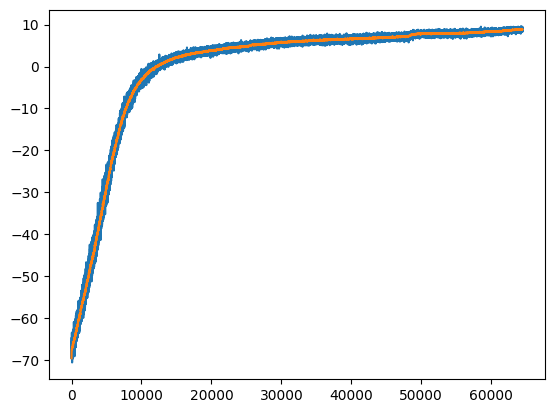

In [6]:
import matplotlib.pyplot as plt
# Generate 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

Show how trained model transits in GridWorld.

In [6]:
with torch.no_grad():
    html_text = "<table>"
    for row in range(GRID_SIZE):
        html_text += "<tr>"
        for col in range(GRID_SIZE):
            if ((row, col) in env.valid_states) or ((row, col) in [(49, 49)]):
                html_text += "<td bgcolor=\"gray\">"
                #
                # get direction
                #
                state_id = row * GRID_SIZE + col
                one_hot_arr = np.zeros(GRID_SIZE * GRID_SIZE, dtype=int)
                one_hot_arr[state_id] = 1
                #   --> size : (1, GRID_SIZE*GRID_SIZE)
                s_batch = np.expand_dims(one_hot_arr, axis=0)
                s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
                #   --> size : (1, 4)
                logits = actor_func(s_batch)
                #   --> size : (4)
                logits = logits.squeeze(dim=0)
                #   --> size : (1)
                index = torch.argmax(logits).tolist()
                #
                # show direction
                #
                if index == 0:
                    html_text += "&#x2191;" # up
                elif index == 1:
                    html_text += "&#x2193;" # down
                elif index == 2:
                    html_text += "&#x2190;" # left
                elif index == 3:
                    html_text += "&#x2192;" # right
            else:
                html_text += "<td>"
            html_text += "</td>"
        html_text += "</tr>"
    html_text += "</table>"

display(HTML(html_text))

,,,,,,→,→,→,→,↓,↓,,↓,,,,,↓,,↓,,→,→,↓,,↓,↓,↓,,,,,→,→,→,↓,,,,,,,,,,,,,
,,,,,,↓,,→,→,→,↓,↓,↓,↓,←,←,←,↓,←,←,,,,↓,,→,↓,←,←,←,,↓,,↑,,↓,,,,,,,,,,,,,
,,,,,,↓,,↑,,→,→,→,←,←,←,←,,↓,←,,→,↓,,→,→,→,↑,←,←,←,,↓,↓,,↓,↓,,,↓,↓,,,,,,,,,
,,,↓,,,↓,↓,,↓,,→,→,←,←,,↓,,↓,,,,→,↓,,,↑,↑,,↑,→,→,→,↓,↓,←,←,←,→,↓,←,,,,,,,,,
,,,↓,→,→,→,→,→,→,→,→,↑,↑,↑,←,←,←,↓,,,↓,,↓,←,→,→,↑,←,→,→,→,→,→,↓,,↑,,→,↓,←,,,,,,,,,
,,,↓,↓,,↓,,→,↑,,↑,↑,,↑,↑,,,↓,←,,→,↓,←,,→,↑,↑,←,,,↑,↑,,↓,,,,,↓,←,,,,,,,,,
,,→,→,→,→,↓,→,→,↑,→,↑,,,,↑,←,→,↓,←,,,↓,←,,,↑,↑,,,,,→,→,→,↓,→,↓,←,,,,,,,,,,,
↓,→,↓,↓,,→,↓,↓,,↑,↑,↑,←,,↓,↑,,,↓,←,,↓,↓,,↓,↓,,→,↓,↓,,,↑,↑,,↓,,↓,,,,,,,,,,,,
→,→,→,→,→,→,→,↓,←,↑,,,↑,,↓,↓,,↓,↓,,,↓,←,←,→,↓,←,,→,↓,↓,,,,,,,↓,,,,,,,,,,,,
→,→,↑,,↑,,→,↓,,,→,↓,,→,→,↓,←,←,→,↓,←,←,,,,↓,,→,→,→,→,→,→,↓,↓,↓,↓,,,,,,,,,,,,,
→,↑,↑,→,↑,,→,→,→,↓,,↓,↓,,→,↓,←,,→,↓,←,,↓,←,,→,↓,↓,,,↑,,,↓,↓,←,←,←,,,,,,,,,,,,↓


## 4. Generate expert trajectories (expert data)

Now we have a trained expert and then generate expert's data with this trained agent.

When using pre-trained models in this repository, please load model as follows.

In [6]:
actor_func.load_state_dict(torch.load("expert_actor.pt"))
value_func.load_state_dict(torch.load("expert_value.pt"))
actor_func = actor_func.eval()
value_func = value_func.eval()

Generate 100,000 trajectories and save in 10 separated files (in which, each file has 10,000 trajectories).

In [7]:
from pathlib import Path
import pickle

# total number of episodes to run
episode_num = 100000
# number of episodes to save in a single checkpoint file
episode_num_in_ckpt = 10000
# batch size to run inference
# (the number of episodes in each file)
inf_batch_size = 100
# directory name to save files
dest_dir = "./expert_data"

assert episode_num % episode_num_in_ckpt == 0
assert episode_num_in_ckpt % inf_batch_size == 0

total_iter_num = int(episode_num / inf_batch_size)

Path(dest_dir).mkdir(exist_ok=True)

with torch.no_grad():
    for i in range(total_iter_num):
        #
        # Run episode till done as a batch to generate tensors
        #
        done = torch.tensor([False]).to(device)
        # define working items
        states_work = torch.empty((inf_batch_size,0), dtype=torch.int).to(device)
        actions_work = torch.empty((inf_batch_size,0), dtype=torch.int).to(device)
        rewards_work = torch.empty((inf_batch_size,0), dtype=torch.float).to(device)
        # define done items
        states_done = []
        actions_done = []
        rewards_done = []
        # start
        s = env.reset(inf_batch_size)
        while not (torch.prod(done) == 1):
            s_onehot = get_feature(s)
            s_row, s_col = torch.split(s, [1,1], dim=1)
            s_idx = (s_row * GRID_SIZE + s_col).squeeze(dim=1)
            states_work = torch.cat((states_work, s_idx.unsqueeze(dim=1)), dim=1)
            a, _, _ = pick_sample_and_logp(actor_func, s_onehot)
            s, r, done = env.step(a, s)
            actions_work = torch.cat((actions_work, a.unsqueeze(dim=1)), dim=1)
            rewards_work = torch.cat((rewards_work, r.unsqueeze(dim=1)), dim=1)
            # pick up batch to be done and append to done-list
            done_indices = done.nonzero().squeeze(dim=1)
            if done_indices.numel() > 0:
                states_done.append(states_work[done_indices,:])
                actions_done.append(actions_work[done_indices,:])
                rewards_done.append(rewards_work[done_indices,:])
            # filter batch to run (not to be done)
            work_indices = (done==False).nonzero().squeeze(dim=1)
            if work_indices.numel() > 0:
                states_work = states_work[work_indices,:]
                actions_work = actions_work[work_indices,:]
                rewards_work = rewards_work[work_indices,:]
            # also filter the current state
            if work_indices.numel() > 0:
                s = s[work_indices,:]

        #
        # Save results as numpy array
        #

        # e.g, [tensor([[1,3,1],[2,1,1]]), tensor([[1,2,1,3]]), ...]

        # split tensors into list of tensors
        # --> [[tensor([[1,3,1]]), tensor([[2,1,1]])], [tensor([[1,2,1,3]])], ...]
        states_done = [torch.split(s, 1, dim=0) for s in states_done]
        actions_done = [torch.split(a, 1, dim=0) for a in actions_done]
        rewards_done = [torch.split(r, 1, dim=0) for r in rewards_done]
        # flatten into 1-dimension list
        # --> [tensor([[1,3,1]]), tensor([[2,1,]]), tensor([[1,2,1,3]]), ...]
        states_done = [s2 for s1 in states_done for s2 in s1]
        actions_done = [a2 for a1 in actions_done for a2 in a1]
        rewards_done = [r2 for r1 in rewards_done for r2 in r1]
        # squeeze in each element
        # --> [tensor([1,3,1]), tensor([2,1,1]), tensor([1,2,1,3]), ...]
        states_done = [s.squeeze(dim=0) for s in states_done]
        actions_done = [s.squeeze(dim=0) for s in actions_done]
        rewards_done = [s.squeeze(dim=0) for s in rewards_done]
        # shuffle
        all_done = list(zip(states_done, actions_done, rewards_done))
        random.shuffle(all_done)
        states_done, actions_done, rewards_done = zip(*all_done)
        states_done, actions_done, rewards_done = list(states_done), list(actions_done), list(rewards_done)
        # get step length in each episode
        step_lens = [a.shape[0] for a in actions_done]
        # flatten
        states_done = torch.cat(states_done, dim=0)
        actions_done = torch.cat(actions_done, dim=0)
        rewards_done = torch.cat(rewards_done, dim=0)
        # to numpy
        states_done = states_done.cpu().numpy()
        actions_done = actions_done.cpu().numpy()
        rewards_done = rewards_done.cpu().numpy()
        step_lens = np.array(step_lens)
        # output progress
        print("Processed {:6d} / {:6d} episodes ...".format(inf_batch_size * (i + 1), episode_num), end="\r")
        # save in each episode_num_in_ckpt
        if (i + 1) % (episode_num_in_ckpt / inf_batch_size) == 1:
            # initialize
            states_store = states_done
            actions_store = actions_done
            rewards_store = rewards_done
            timestep_lens_store = step_lens
        else:
            # add to list
            states_store = np.concatenate((states_store, states_done), axis=0)
            actions_store = np.concatenate((actions_store, actions_done), axis=0)
            rewards_store = np.concatenate((rewards_store, rewards_done), axis=0)
            timestep_lens_store = np.concatenate((timestep_lens_store, step_lens), axis=0)
            # save
            if (i + 1) % (episode_num_in_ckpt / inf_batch_size) == 0:
                ckpt_num = int((i + 1) / (episode_num_in_ckpt / inf_batch_size) - 1)
                with open(f"{dest_dir}/ckpt{ckpt_num}.pkl","wb") as f:
                    pickle.dump({
                        "states": states_store,
                        "actions": actions_store,
                        "rewards": rewards_store,
                        "timestep_lens": timestep_lens_store,
                    }, f)
print("\nDone")

Processed 100000 / 100000 episodes ...
Done
